In [13]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import math as mt
import matplotlib.pyplot as plt

2.6.0


In [14]:
a1=45*np.sqrt(5)
a2=24*np.sqrt(806115)
a3=1560*np.sqrt(49407661)


In [16]:
def basis_fct(k,t):
    if k==1:
        return 1+0*t
    if k==2:
        return -1+np.exp(-t)
    if k==3:
        return np.exp(-t)*t
    if k==4:
        return (1/2)*(-2*np.exp(-t)*t+np.exp(-t)*np.power(t,2))
    if k==5:
        return (-6*np.exp(-t)*t-36*np.exp(-t)*np.power(t,2)+np.exp(-t)*np.power(t,3))/a1
    if k==6:
        return (-24*np.exp(-t)*t-192*np.exp(-t)*np.power(t,2)-1440*np.exp(-t)*np.power(t,3)+np.exp(-t)*np.power(t,4))/a2
    if k==7:
        return (-120*np.exp(-t)*t-1200*np.exp(-t)*np.power(t,2)-10800*np.exp(-t)*np.power(t,3)+100800*np.exp(-t)*np.power(t,4)+np.exp(-t)*np.power(t,5))/a3
    else:
        return 0

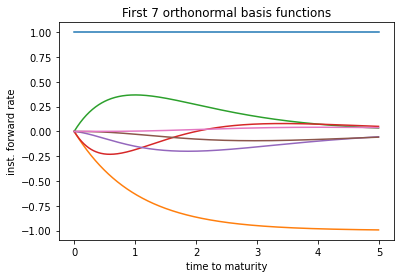

In [17]:
# Plot our basis functions
t = np.arange(0.0, 5.0, 0.01)
e1 =basis_fct(1,t)
e2 =basis_fct(2,t)
e3 =basis_fct(3,t)
e4 =basis_fct(4,t)
e5 =basis_fct(5,t)
e6 =basis_fct(6,t)
e7 =basis_fct(7,t)

fig=plt.figure()
ax=plt.axes()

ax.set(xlabel='time to maturity', ylabel='inst. forward rate',
       title='First 7 orthonormal basis functions')
ax.plot(t,e1)
ax.plot(t,e2)
ax.plot(t,e3)
ax.plot(t,e4)
ax.plot(t,e5)
ax.plot(t,e6)
ax.plot(t,e7)

plt.show()

Now calculate the outputs...

In [18]:
StartingValues=np.load('startingvaluesMultiVariate.npy')
TrainingSize=StartingValues.shape[0]
print(TrainingSize)
print(StartingValues)

10000000
[[ 0.36999885  0.06088184 -0.27843507 ...  0.05552605  0.27597337
   0.46055534]
 [ 0.41627211 -0.32638021  0.30962175 ...  0.10310086 -0.32621497
  -0.0346609 ]
 [ 0.45123417  0.28628765 -0.34419823 ...  0.17506217 -0.22866537
   0.30101809]
 ...
 [ 0.2657931  -0.06870523 -0.13819409 ...  0.24828656  0.03992342
   0.29094948]
 [-0.12807186  0.42792914  0.27162283 ... -0.05987048 -0.47285047
  -0.04101031]
 [ 0.38745462  0.36525259 -0.33679535 ... -0.19790725 -0.3148698
  -0.31740994]]


In [19]:
def evalCurve0(x,tau):
    xSize=x.size
    Y0=np.zeros(tau.size)
    for k in range(1,xSize+1,1):
        Y0+=x[k-1]*basis_fct(k,tau)
    return np.exp(Y0)


# Simulate one Brownian motion from 0 to T. We discretize daily 
T=1/12#one month simulation time horizon 
L=30#Discretization of BM
s = np.arange(0.0, 1/12, 1/(12*L))
Tminuss=T-s
print(Tminuss)
deltaS=1/(12*L)
Ssize=s.size

# [x1,..,x10] starting value x1e1 +...+ x10e10
def evalCurve(x,BMInc,tau):
    sqrtdeltaS=mt.sqrt(deltaS)
    xSize=x.size
    TauSize=tau.size
    Y0=np.zeros(TauSize)
    drift=np.zeros(TauSize)
    noise=np.zeros(TauSize)
    for k in range(1,xSize+1,1):
        Y0+=x[k-1]*basis_fct(k,tau+T)
        for j in range(0,L,1):
            tmp=basis_fct(k,tau+Tminuss[j])
            drift+=tmp*tmp*deltaS
            noise+=tmp*BMInc[k-1,j]*sqrtdeltaS
        #tmp+=x[k]*np.power(t+T,k-1)*mt.exp(-(t+T))
    return np.exp(Y0-(1/2)*drift+noise)#mt.exp(-(1/2)*T+mt.sqrt(T)*BMInc +tmp)


discretizationDimension=10#either 10 or 20
#discretize only the interval [0,1/12] as everything outside of this interval is irrelevant for the option we price
xGrid=np.linspace(0,1/12,discretizationDimension)

xValues=np.zeros([TrainingSize,discretizationDimension])

for sample in range(0,TrainingSize,1):
    xValues[sample,:]=evalCurve0(StartingValues[sample,:],xGrid)


[0.08333333 0.08055556 0.07777778 0.075      0.07222222 0.06944444
 0.06666667 0.06388889 0.06111111 0.05833333 0.05555556 0.05277778
 0.05       0.04722222 0.04444444 0.04166667 0.03888889 0.03611111
 0.03333333 0.03055556 0.02777778 0.025      0.02222222 0.01944444
 0.01666667 0.01388889 0.01111111 0.00833333 0.00555556 0.00277778]


In [20]:
print(xValues)
np.save('DiscretizedCurve10TrainingsetMultivariate',xValues)

[[1.44773295 1.4458744  1.44401456 ... 1.43470962 1.43285008 1.43099186]
 [1.51629841 1.52836335 1.54030305 ... 1.5980962  1.6092695  1.62031326]
 [1.57024895 1.55602106 1.54217329 ... 1.47825011 1.46645687 1.45497186]
 ...
 [1.30446514 1.30083284 1.29728945 ... 1.28084271 1.27779534 1.27482479]
 [0.87979016 0.88237104 0.88484809 ... 0.89572345 0.89760635 0.89939522]
 [1.47322609 1.46696242 1.46078505 ... 1.43115077 1.42546627 1.4198599 ]]


In [21]:
startingValuesTestset=np.zeros([9600,7])
MCprices=np.zeros([9600])
for k in range(0,30,1):
    tmpstring="% s" % k
    filename1="startingvaluesMultiVariateTestset100000Sim"+tmpstring+".npy"
    filename2="outputsMultiVariateTestset100000Sim"+tmpstring+".npy"
    tmp1=np.load(filename1)
    tmp2=np.load(filename2)
    startingValuesTestset[k*320:(k+1)*320]=tmp1
    MCprices[k*320:(k+1)*320]=tmp2




In [22]:
testsize=MCprices.size
xValues=np.zeros([testsize,discretizationDimension])

for sample in range(0,testsize,1):
    xValues[sample,:]=evalCurve0(startingValuesTestset[sample,:],xGrid)



In [23]:
print(xValues)

[[1.53911892 1.54385504 1.54851292 ... 1.57066924 1.57488198 1.57902457]
 [0.73532335 0.7341114  0.73296006 ... 0.72805959 0.7272407  0.72647238]
 [0.967596   0.96641899 0.96518933 ... 0.95831233 0.956803   0.95525283]
 ...
 [0.93882147 0.9418031  0.94476945 ... 0.95937871 0.96225737 0.96512205]
 [0.75580757 0.76133538 0.76676908 ... 0.79251737 0.79738216 0.80215198]
 [1.56050251 1.56165453 1.56267937 ... 1.56597904 1.5662906  1.56649151]]


In [24]:
np.save('DiscretizedCurve10TestsetMultivariate',xValues)#10 or 20

In [25]:
np.save('outputsMultiVariateTestset100000Simulations',MCprices)